# Data management

Pierre LETOURNEAU

## Introduction

This notebook contains the data cleaning, preprocessing, and exploratory data analysis for the manuscript . All steps are performed using R.

In [ ]:
#| label: setup
#| code-fold: true
#| code-summary: "Show the code"
suppressWarnings(suppressPackageStartupMessages({
  library(tidyverse)
  library(janitor)
  library(summarytools)
  library(ggthemes)
  library(ggsci)
  library(performance)
  library(gtsummary)
}))

# theme plot

theme_scipub <- function() {
  theme_bw() +
    theme(
      # Éléments de texte
      text = element_text(family = "sans", size = 12),
      
      # Titres et légendes
      plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, hjust = 0.5),
      axis.title = element_text(size = 12, face = "bold"),
      axis.text = element_text(size = 10, colour = "black"),
      legend.title = element_text(size = 12, face = "bold"),
      legend.text = element_text(size = 10),
      
      # Axes et lignes
      panel.grid.major = element_line(linetype = "dashed", colour = "grey80"),
      panel.grid.minor = element_blank(),
      axis.line = element_line(colour = "black"),
      
      # Fond et bordure
      panel.background = element_blank(),
      panel.border = element_blank(),
      
      # Légende
      legend.position = "bottom",
      legend.box.background = element_rect(colour = "grey80"),
      
      # Facettes (si vous utilisez `facet_wrap` ou `facet_grid`)
      strip.background = element_rect(fill = "grey90", colour = "black"),
      strip.text = element_text(face = "bold")
    )
}

theme_set(theme_scipub())

## Data Import and Initial Cleaning

First, we import the raw data and perform initial cleaning steps, including converting variable names to a consistent format and removing unnecessary columns.

In [ ]:
#| label: import-data
#| code-fold: true
#| code-summary: "Show the code"

d <- readRDS("C:/Users/letourneaupi/Desktop/Aurelie_Romane/Data.RDS")

#  distinct(d,id,"date DFG")  # no duplicate


suppressWarnings({
  d=clean_names(d)



# Initial variable selection and renaming for clarity
d2 <- d |>
  dplyr::select(-c(nom, prenom, date_de_naissance, b2mg, b2mg_creat, b2mg_creat_normal_40_7, crp, coeff_a, calcemie, phosphoremie, limite_tm_p,
    limite_tm_p_2, tm_p_gfr_normal, calcium_norme_inf, calcium_norme_sup, phosphore_norme_inf,
    phosphore_norme_sup, tm_p_gfr_norme_inf, tm_p_gfr_norme_sup, date_de_naissance, date_dfg, dfg_brut_nc
  )) |>
  rename(
    creat_sg = creat_sg_mmol_l,
    uree_sg = uree_mmol_l,
    acu_sg = ac_usg,
    na_sg = nasg,
    k_sg = ksg,
    mg_sg = mgsg,
    ca_sg = casg,
    po4_sg = po4sg,
    cl_sg = clsg,
    prot_sg = protsg,
    bicar_sg = bicarsg,
    gluc_sg = glucsg,
    k_u = ku,
    acu_u = ac_ur_u,
    po4_u = po4u,
    dfg_ml_min = df_gml_min,
    dfg_ml_min_m2 = df_gml_min_1_73,
    eptpc = e_p_tpc,
    upv_crcl = up_v_cr_cl,
    trp = trp_percent,
    tmp_gfr_nc = tm_p_gfr_non_corrige,
    trp_sup85 = trp_85_percent,
    tmp_gfr_kenny = tm_p_gfr_corr_kenny,
    tmp_final = tm_p_final,
    hypoca = limite_ca,
    hyperca = limite_ca_2,
    hypopo4 = limite_p,
    hyperpo4 = limite_p_2,
    classe_po4 = phosphoremie_classe,
    classe_ca = classe_calcemie,
    classe_tmp_gfr = tm_p_gfr_classe,
    eptpc_075 = e_p_tpc_seuil_0_75
  )

# List of numerical variables to transform
vars_num_to_transform <- c("poids_kg_a_12_mois", "taille_cm",
  "acu_sg", "po4_sg", "prot_sg", "ca_sg",
  "creat_sg", "na_sg", "k_sg", "cl_sg", "bicar_sg", "mg_sg",
  "gluc_sg", "creat_u", "uree_u", "na_u", "k_u", "acu_u",
  "cl_u", "mg_u", "ca_u", "po4_u", "prot_u", "alb_u",
  "osm_u", "gluc_u", "eptpc", "dfg_ml_min",
  "dfg_ml_min_m2", "upv_crcl", "trp", "tmp_final", "alb_creat"
)

# Apply numerical transformation
d3 <- d2 %>%
  ungroup() |>
  mutate(across(.cols = all_of(vars_num_to_transform),
                .fns = ~ case_when(
                  str_detect(., "<") ~ as.numeric(str_replace(., "< ", "")) / 2,
                  str_detect(., ">") ~ as.numeric(str_replace(., "> ", "")) * 2,
                  TRUE ~ as.numeric(.)
                )))

# List of categorical variables to convert to factor
vars_to_factor <- c(
  "sexe",
  "etio",
  "code_etio",
  "etio_simplifiee",
  "alb_creat_classe",
  "classe_ckd",
  "classe_ckd_simp",
  "classe_ca",
  "classe_po4",
  "classe_tmp_gfr",
  "inuline_iohexol",
  "trp_sup85",
  "hypoca",
  "hyperca",
  "hypopo4",
  "hyperpo4",
  "eptpc_075"
)

d3 = d3 |>mutate(etio_simplifiee=replace_na(etio_simplifiee,"NA")) |>
  mutate(etio_simplifiee=case_when(
    etio_simplifiee %in% c("kidney transplantation", "non renal transplantation", "renal risk") ~ etio_simplifiee,
    etio_simplifiee == "NA" & hypopo4 =="normal" & hyperpo4 =="normal" & 
      ((age < 40 & dfg_ml_min_m2 >= 90) | (age >= 40 & dfg_ml_min_m2 >= 80)) ~ "control",
    TRUE ~ "Unknown"
  ))


# Apply conversion to factors
d3 <- d3 |>
  mutate(across(.cols = all_of(vars_to_factor),
                .fns = ~ as.factor(.)))








})

## Descriptive Statistics and Data Structure

We examine the data structure and look for duplicates or missing values to ensure data integrity.

In [ ]:
#| label: descriptive-stats
#| code-fold: true
#| code-summary: "Show the code"

# Summary of column types for verification
print(dfSummary(d3, 
                varnumbers   = FALSE, 
                valid.col    = FALSE, 
                graph.magnif = 0.75),
      method = "render")

Generated by summarytools 1.0.1 ( R version 4.4.0) 2025-09-03

We remove important missing data

In [ ]:
#| label: descriptive-stats-wo-NA
#| code-fold: true
#| code-summary: "Show the code"

# Drop rows where key variables are missing
  d3 <- d3 |>drop_na(dfg_ml_min_m2, po4_sg, ca_sg, creat_sg, eptpc)


print(dfSummary(d3, 
                varnumbers   = FALSE, 
                valid.col    = FALSE, 
                graph.magnif = 0.75),
      method = "render")

Generated by summarytools 1.0.1 ( R version 4.4.0) 2025-09-03

### Visit Distribution

We analyze the number of visits per patient to understand the longitudinal nature of the data.

In [ ]:
#| label: visit-distribution
#| code-fold: true
#| code-summary: "Show the code"

# Number of patients with at least one visit
n_patients_with_visit_1 <- d3 |> filter(visite == 1) |> nrow()
cat("Number of patients with at least one visit: ", n_patients_with_visit_1, "\n")

Number of patients with at least one visit:  4983 

Total unique visits in the dataset:  8575 


   1    2    3    4    5    6    7    8    9   10 
5631 1469  694  369  205  108   59   27   11    2 

## Part 1 : relationships between eptpc and others markers

This section focuses on analyzing the relationships between key markers and renal function metrics. We will only consider the **first visit** for each patient for this cross-sectional analysis.

In [ ]:
#| label: eda-part1
#| code-fold: true
#| code-summary: "Show the code"

# Filter for the first visit and select variables of interest for Part 1 analysis
d_p1 <- d3 |>
  filter(visite == 1) |>
  dplyr::select(age, eptpc, sexe, tmp_final, po4_sg, ca_sg, trp, dfg_ml_min,
                dfg_ml_min_m2, etio_simplifiee, classe_ckd_simp, po4_u, ca_u, tmp_final, trp, creat_sg)

# Check for missing values in other key markers
cat("Number of patients with missing tmp_final:", sum(is.na(d_p1$tmp_final)), "\n")

Number of patients with missing tmp_final: 0 

Number of patients with missing trp: 0 

Generated by summarytools 1.0.1 ( R version 4.4.0) 2025-09-03

### Distribution of the EPTpc Marker

We examine the distribution of the primary marker of interest. The histogram shows a continuous, right-skewed, and zero-truncated distribution, suggesting a **gamma** or **log-normal** distribution may be appropriate.

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.001541 0.279532 0.413586 0.468976 0.580464 4.852800 

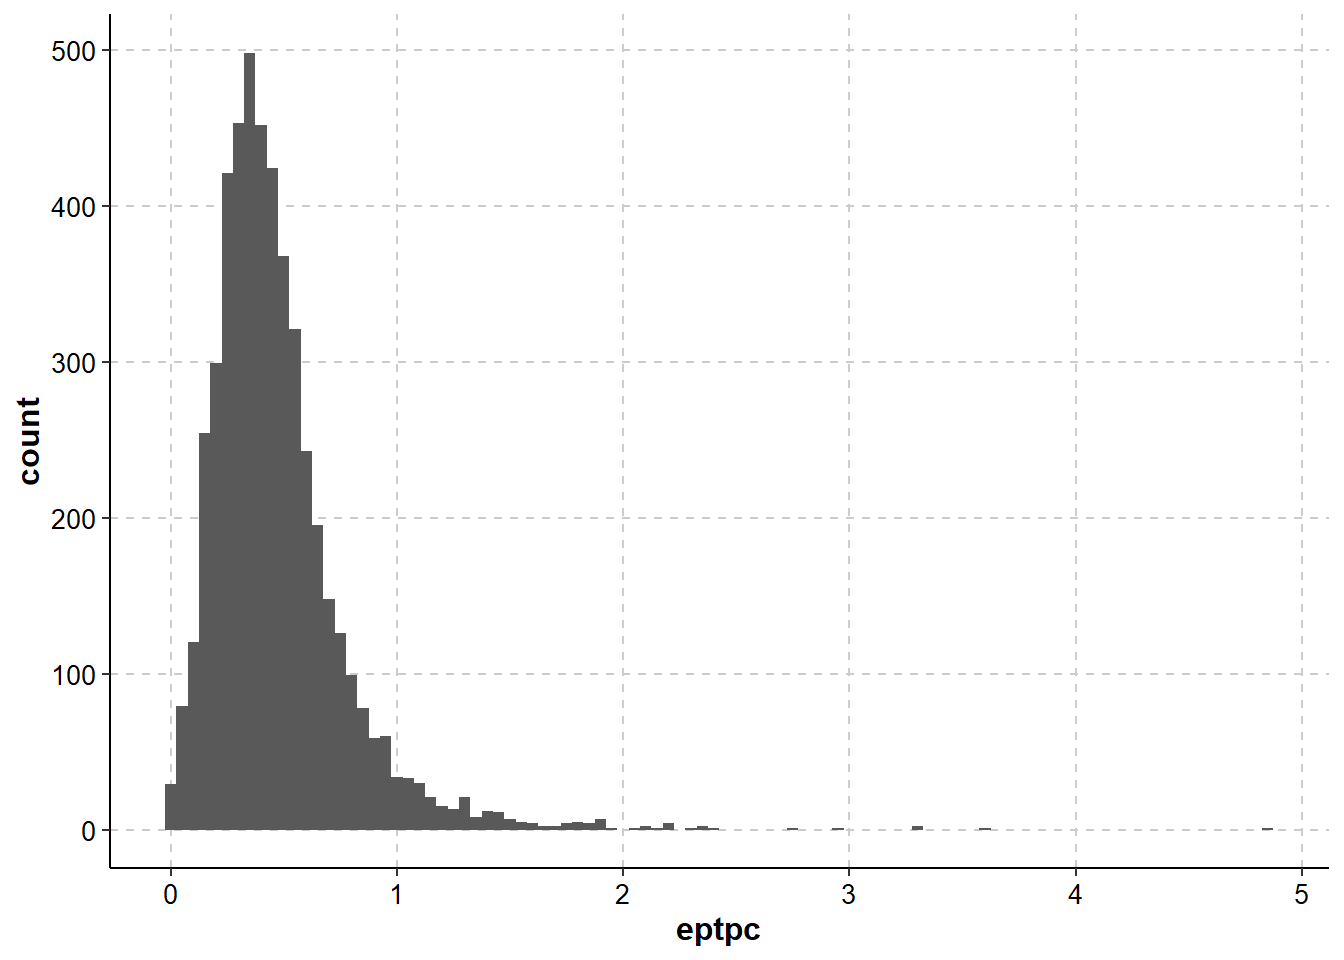

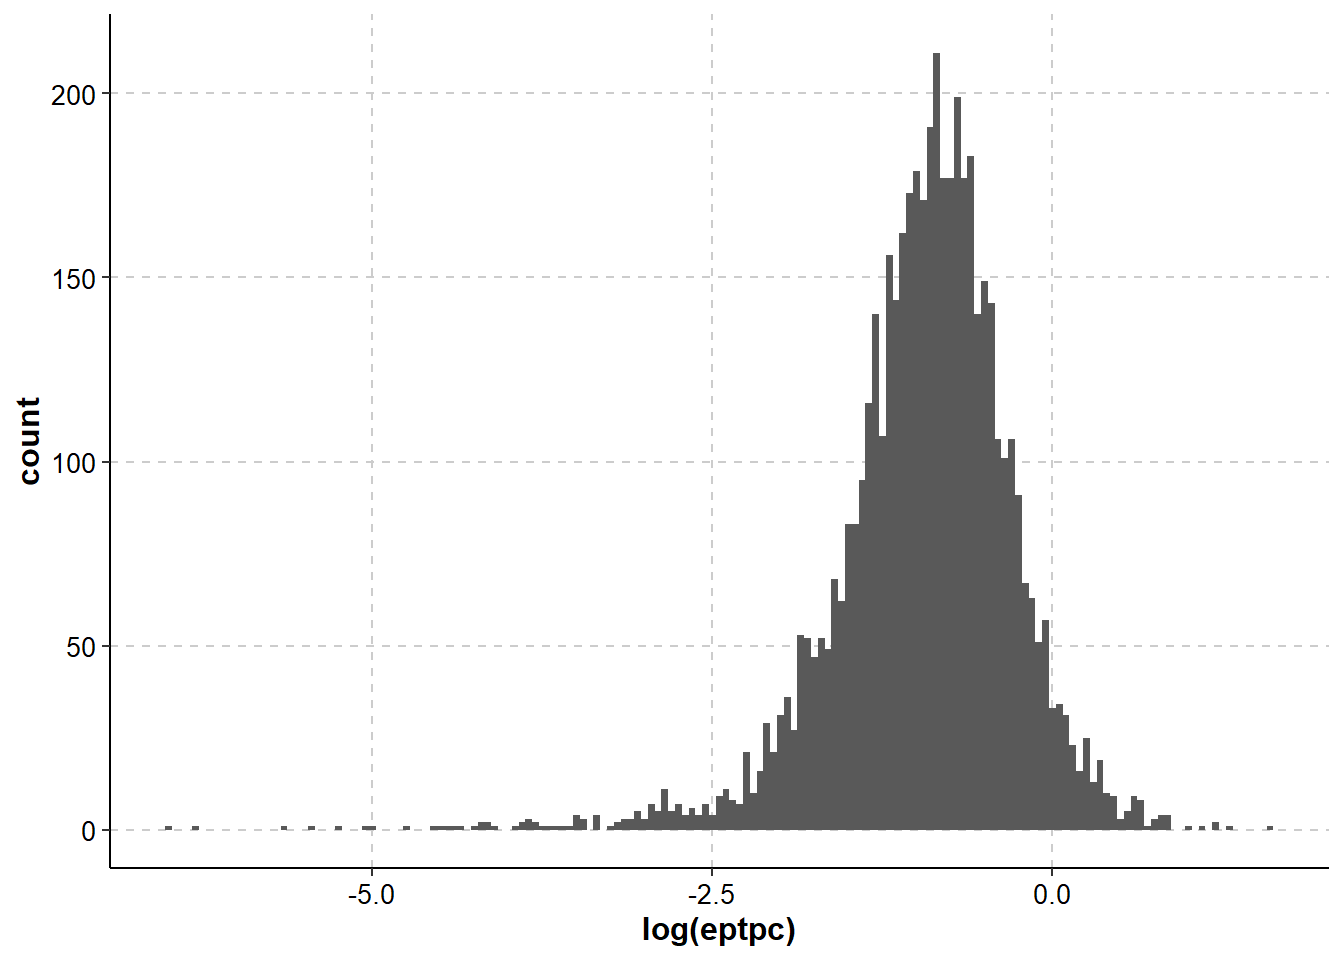

In [ ]:
#| label: eptpc-distribution
#| code-fold: true
#| code-summary: "Show the code"

summary(d_p1$eptpc)

### Markers vs. GFR and Age

Here, we visualize how key markers relate to GFR and age, and check for the influence of CKD severity.

#### ePTpc

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'

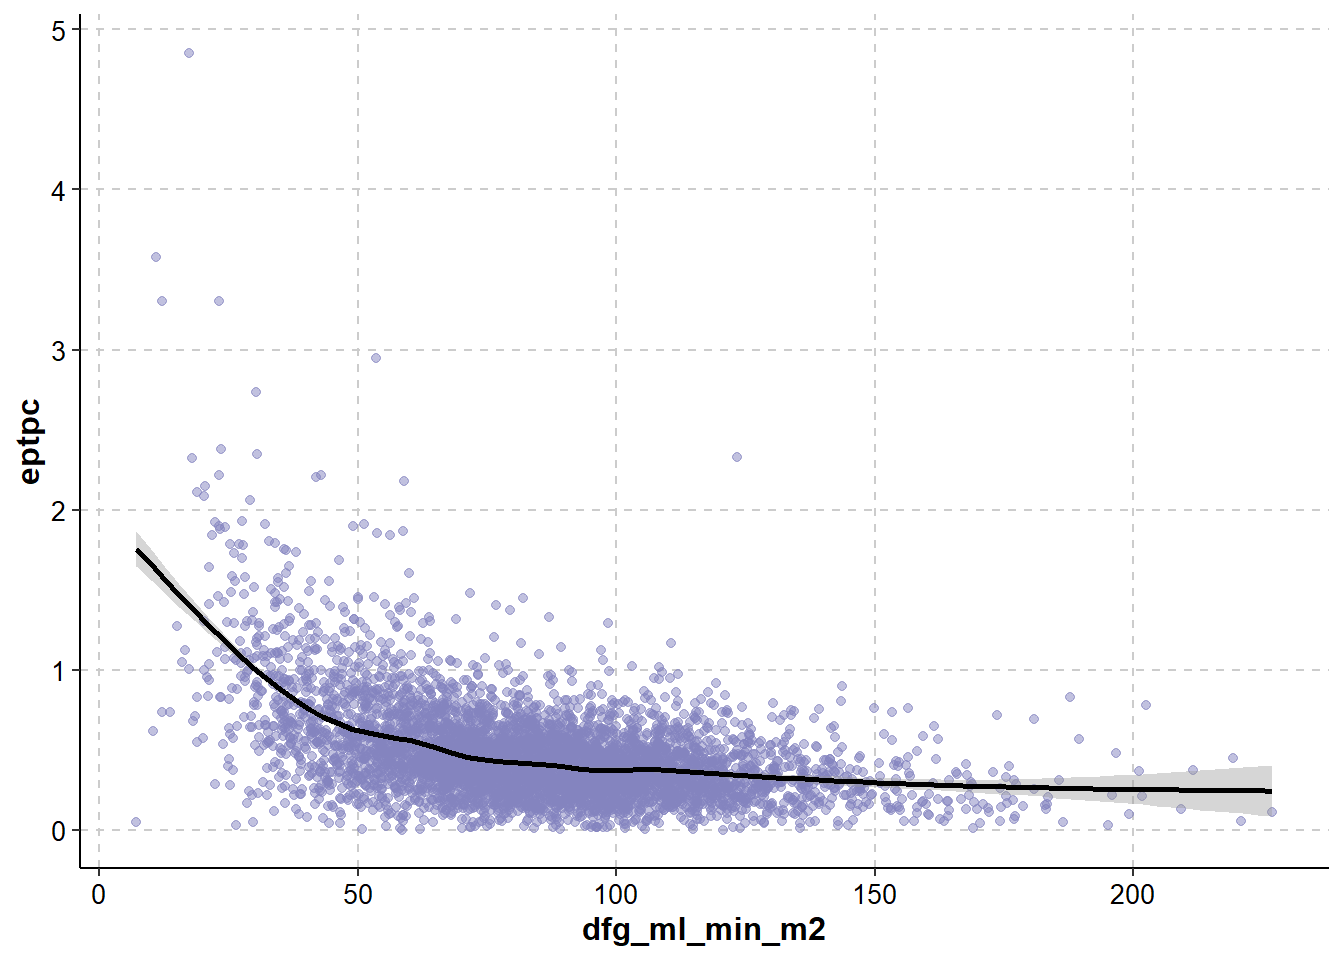

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'

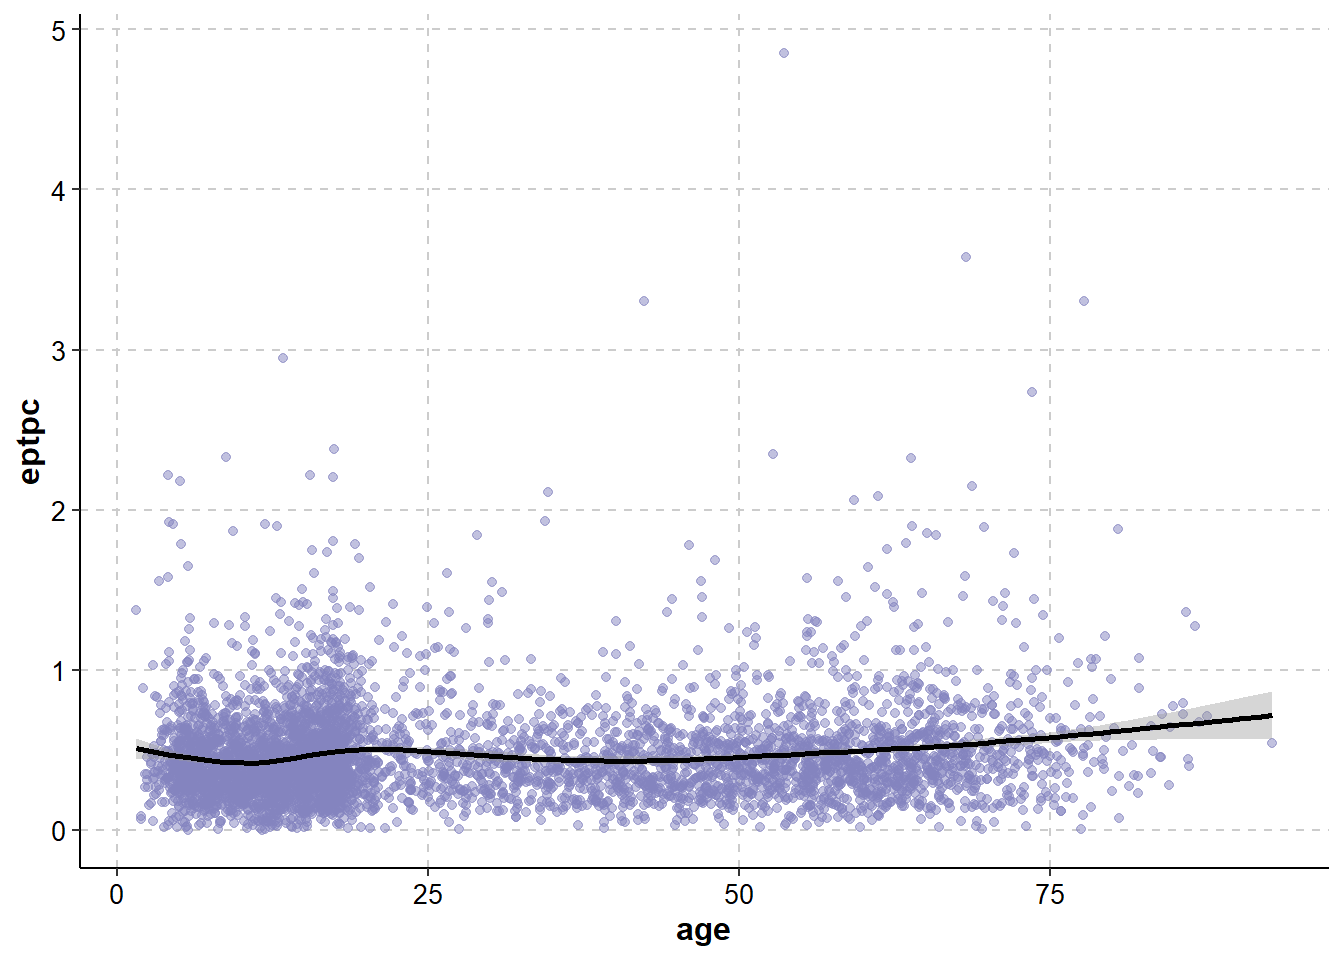

In [ ]:
#| label: marker-vs-gfr-age-1
#| code-fold: true
#| code-summary: "Show the code"

### EPTpc en fonction du DFG
d_p1 |>
  ggplot(aes(x = dfg_ml_min_m2, y = eptpc)) +
  geom_point(alpha = 0.5, color = "#8484BF") +
  geom_smooth(color = "black")

The marker appears to be constant with age. Are the high points outliers? Let’s try to find an explanation. Is it related to the severity of CKD?

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'

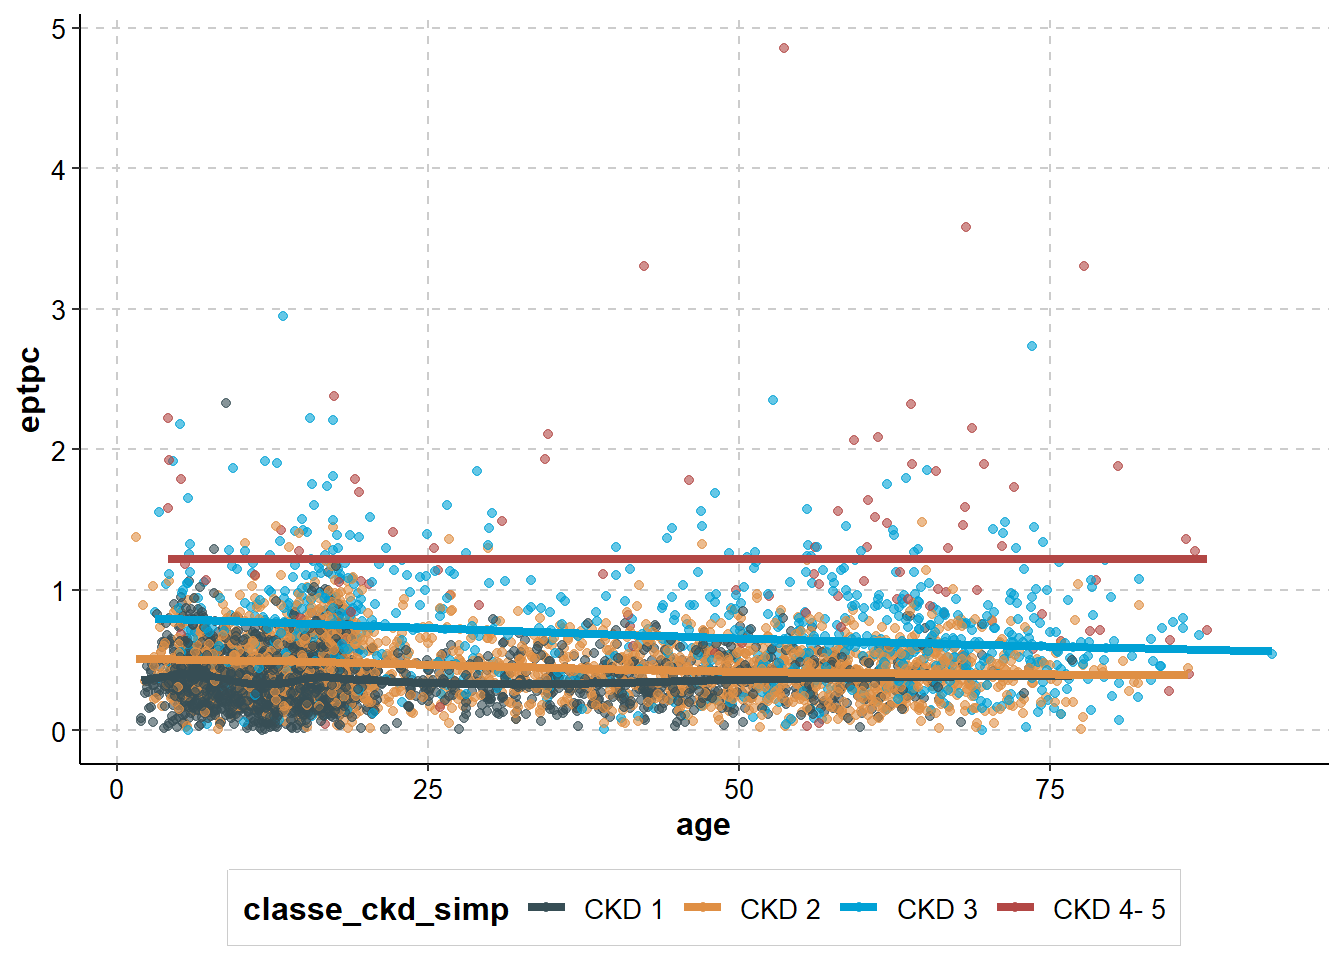

In [ ]:
#| label: marker-vs-gfr-age-1.b
#| code-fold: true
#| code-summary: "Show the code"

### EPTpc with CKD class
d_p1 |>
  ggplot(aes(x = age, y = eptpc, color = classe_ckd_simp)) +
  geom_point(alpha = 0.6) +
  geom_smooth(linewidth = 1.5, se = F) +
  scale_color_jama()

It seems quite clear that CKD explains these points, and age appears to have little influence on this marker.

Let’s look at other concurrent markers. TMP/GFR and TRP

#### Tmp/GFR

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'

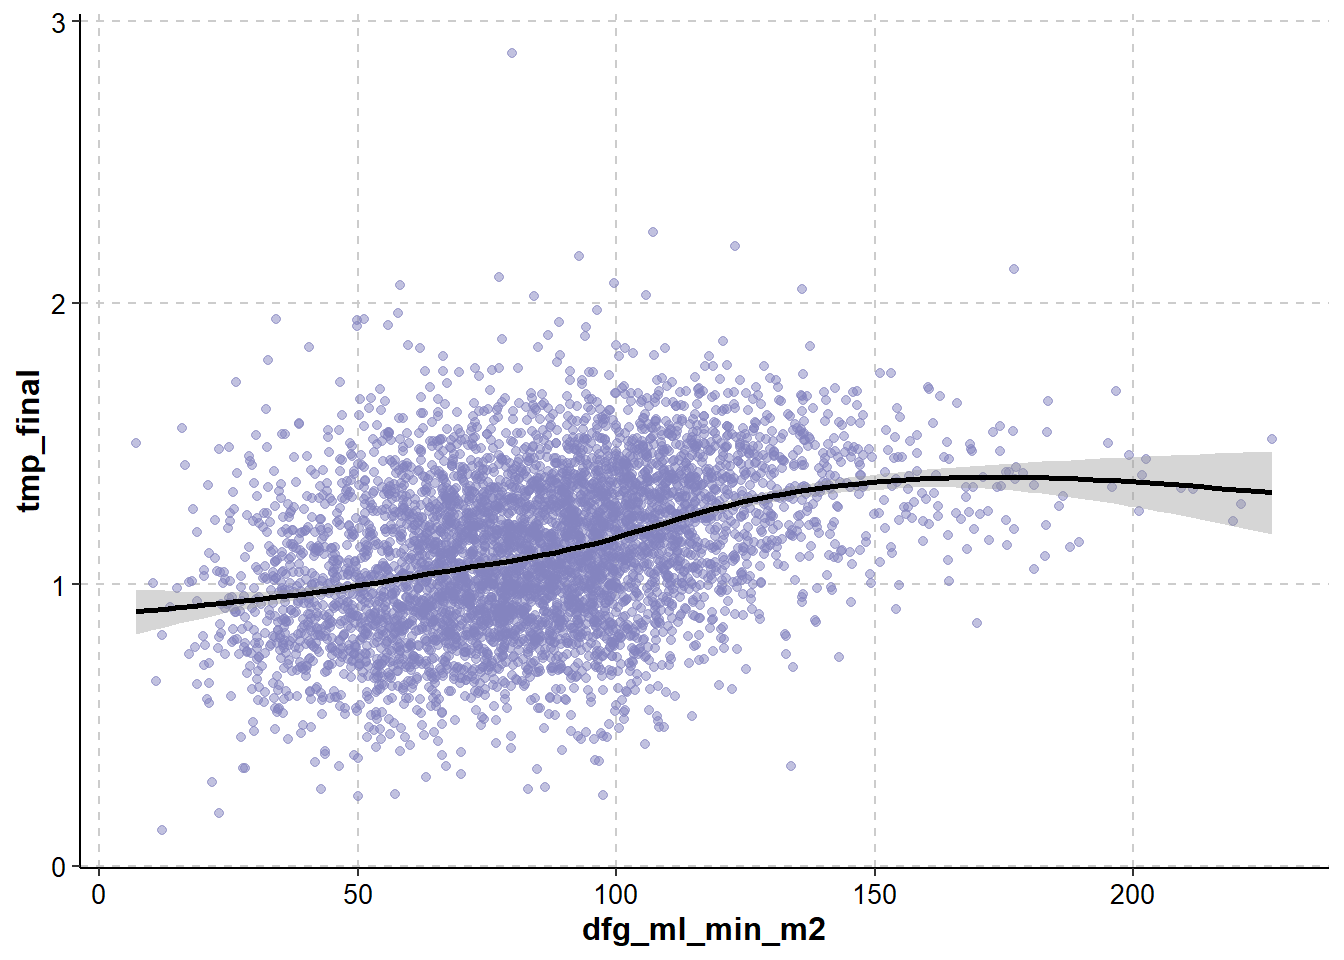

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'

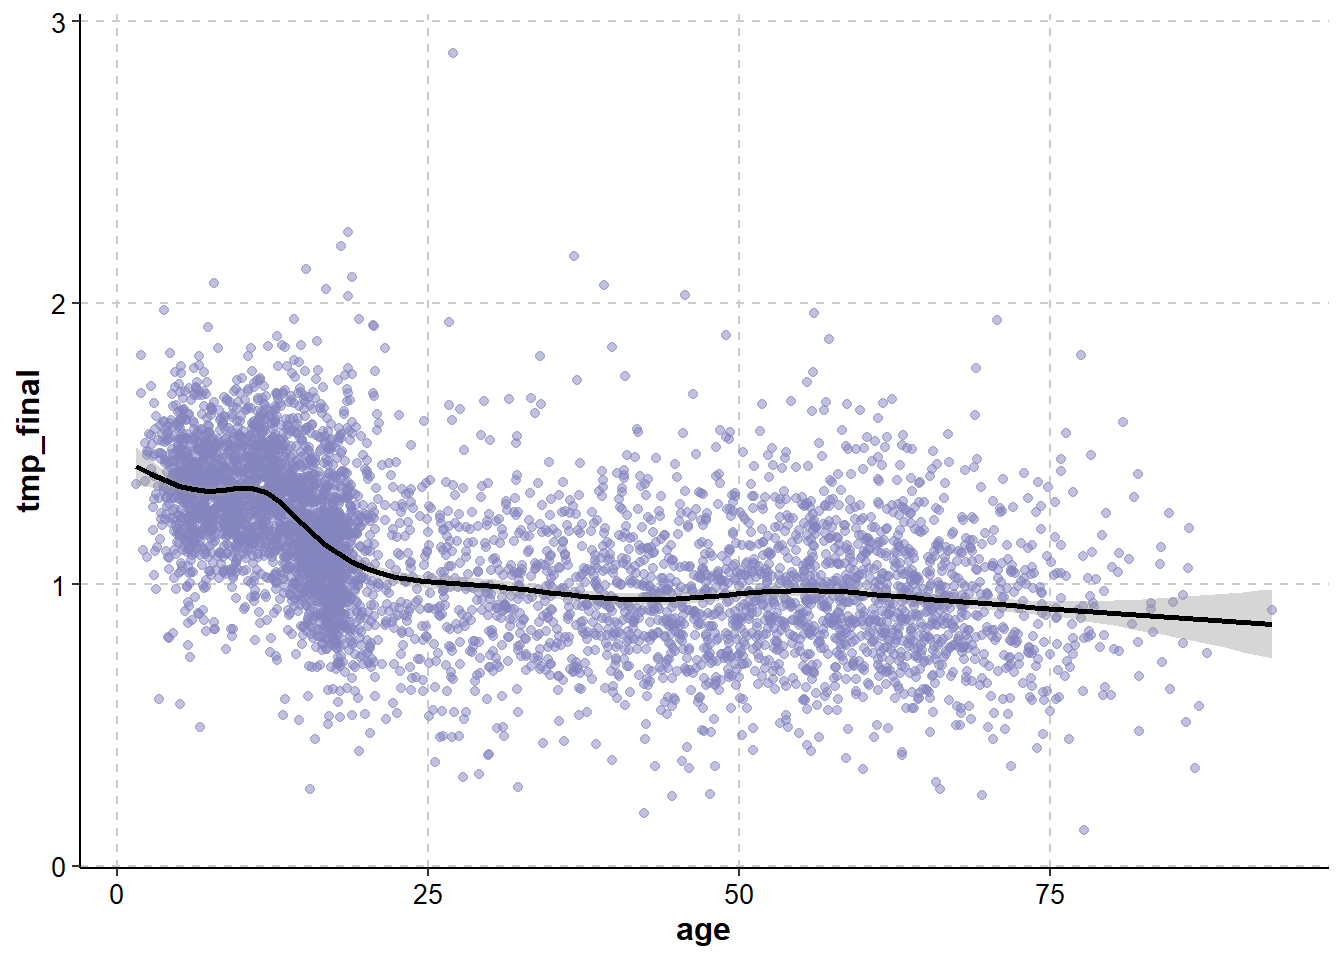

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'

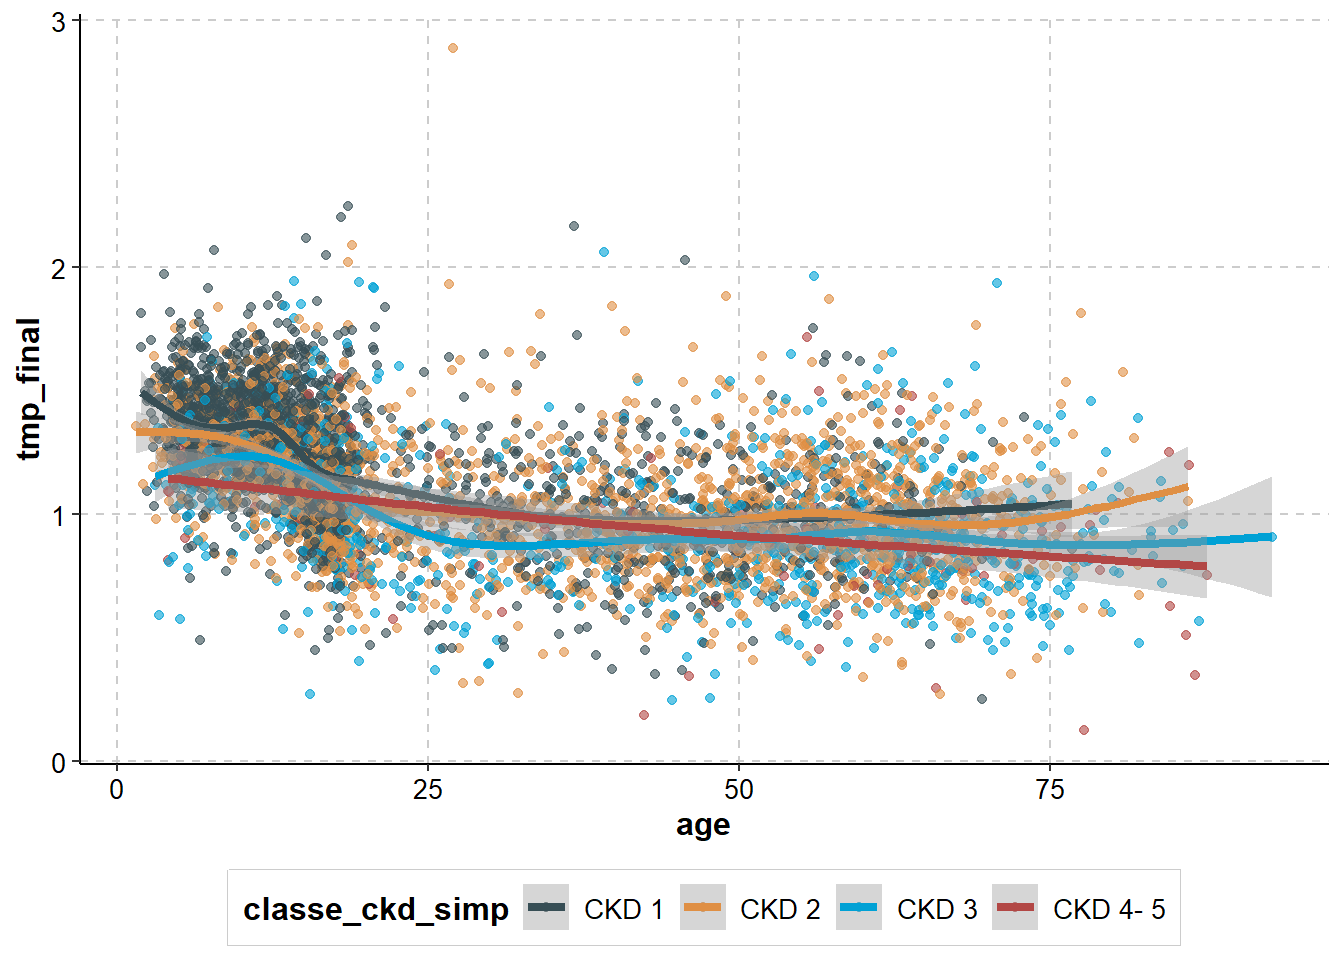

In [ ]:
#| label: marker-vs-gfr-age-2
#| code-fold: true
#| code-summary: "Show the code"

### TMP/GFR with DFG
d_p1 |>
  ggplot(aes(x = dfg_ml_min_m2, y = tmp_final)) +
  geom_point(alpha = 0.5, color = "#8484BF") +
  geom_smooth(color = "black")

TMP/GFR is high in children until puberty, then it drops to stabilize in adulthood, with an effect also from renal function. As GFR decreases, TMP/GFR also decreases with no clear interaction.

#### TRP

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'

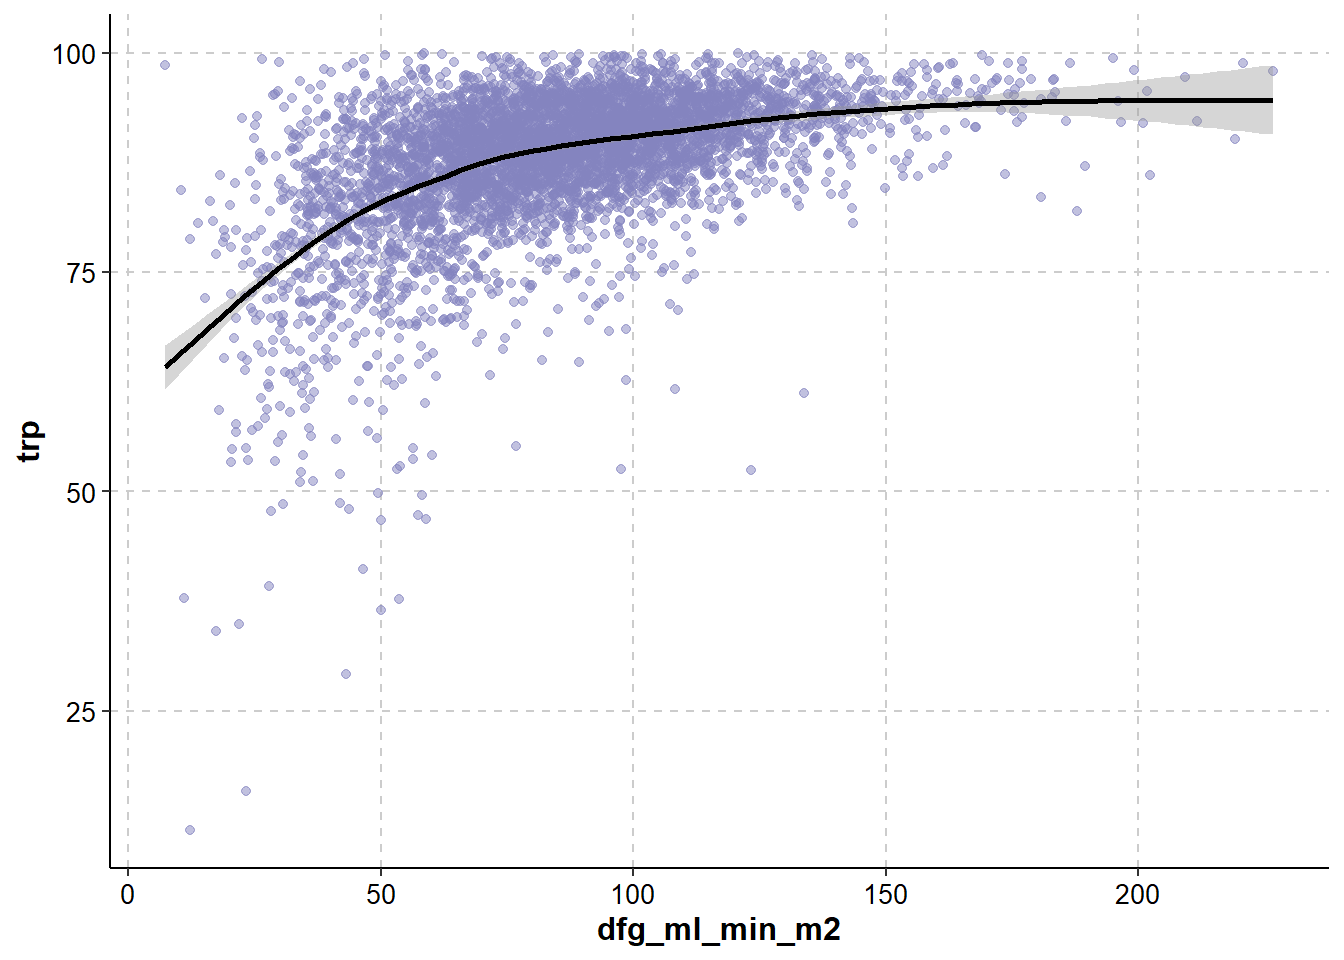

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'

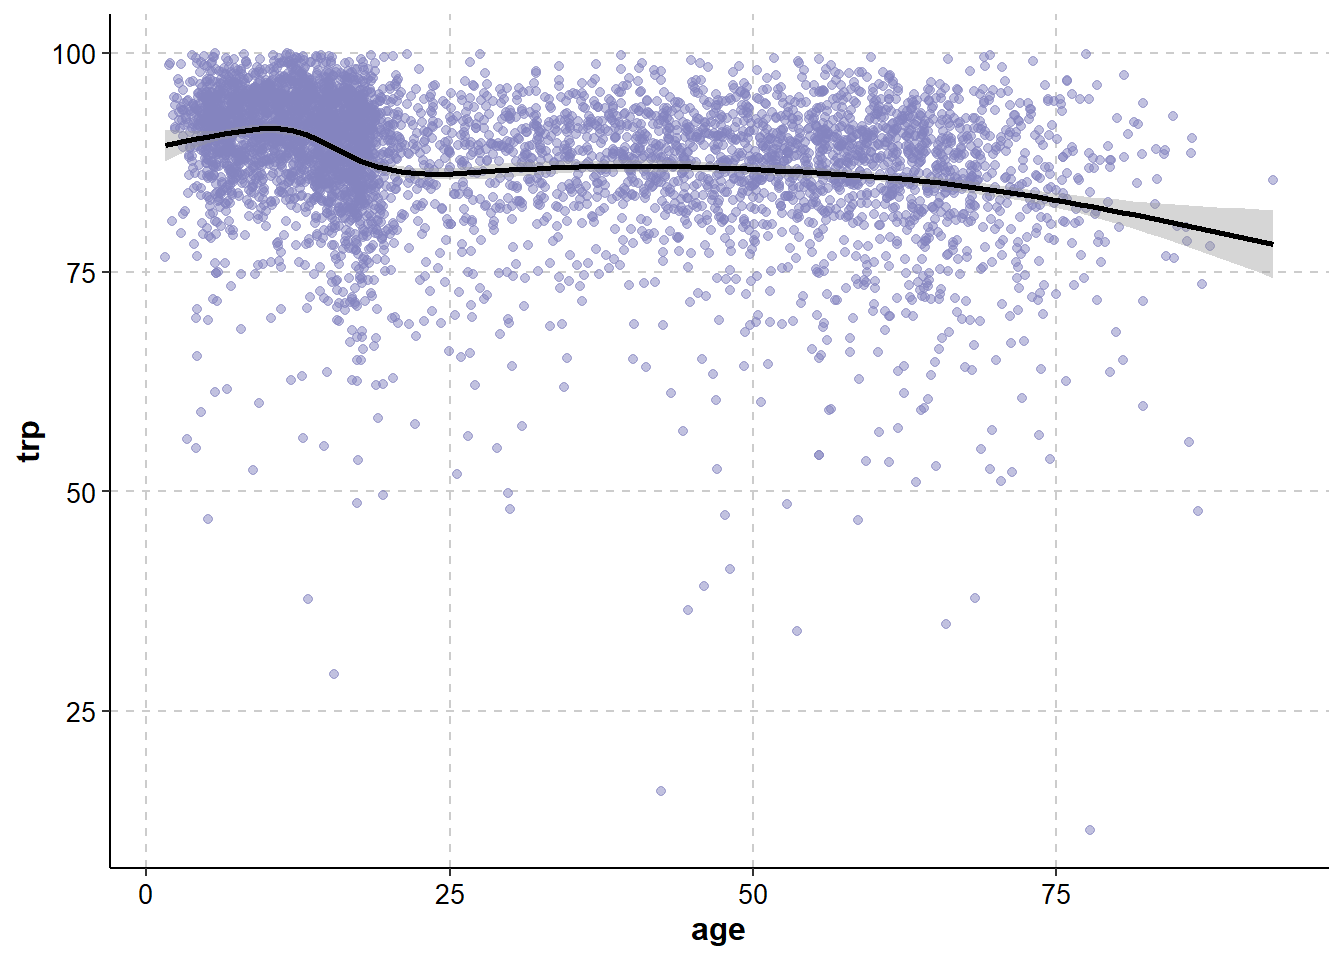

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'

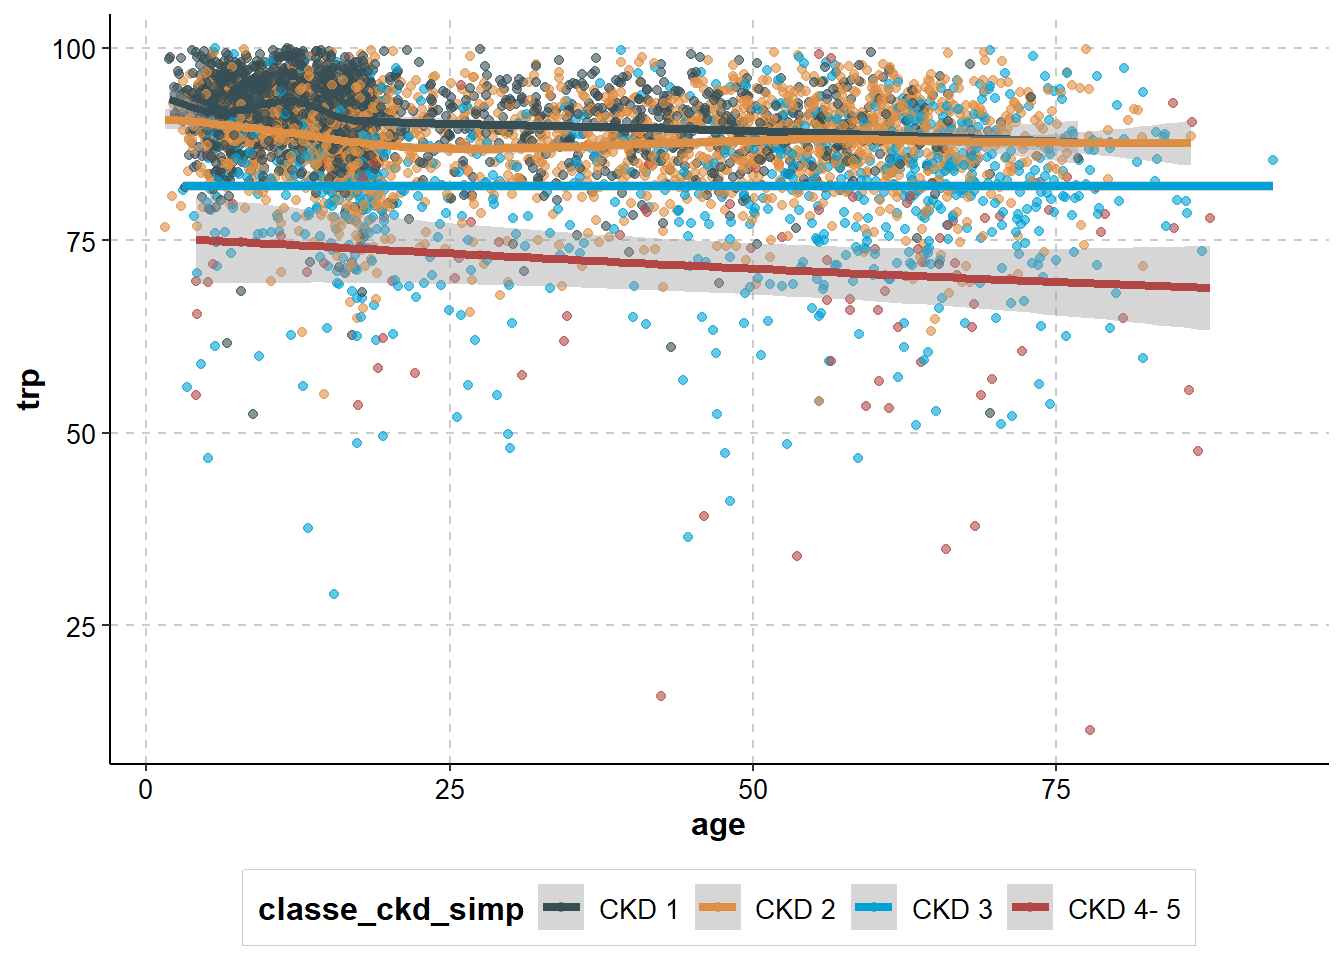

In [ ]:
#| label: marker-vs-gfr-age-3
#| code-fold: true
#| code-summary: "Show the code"

d_p1 |>
  ggplot(aes(x = dfg_ml_min_m2, y = trp)) +
  geom_point(alpha = 0.5, color = "#8484BF") +
  geom_smooth(color = "black")

TRP is very dependent on GFR but little/not at all on age.

### Comparison of Multiple Markers

To compare the multiple markers with different value ranges, we normalize them and plot on a single graph.

#### With GFR

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'

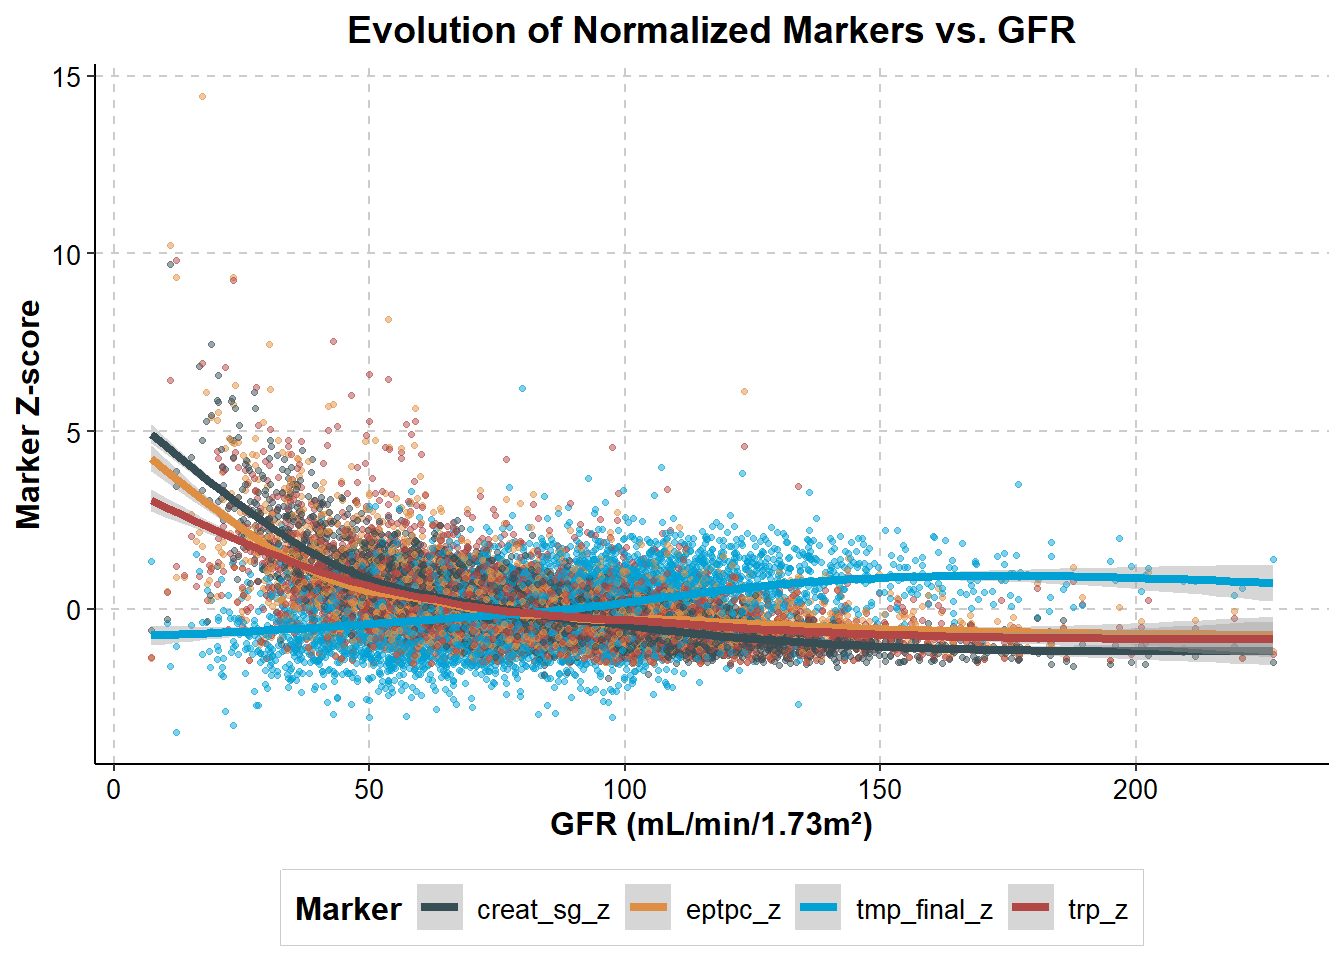

In [ ]:
#| label: multiple-markers
#| code-fold: true
#| code-summary: "Show the code"

# 1. Normalize markers to Z-scores
d_p1 <- d_p1 %>%
  mutate(across(c(eptpc, trp, tmp_final, creat_sg),
    .fns = list(z = ~ scale(.) %>% as.numeric()),
    .names = "{.col}_z"
  ))

# 2. Reshape data to "long" format for ggplot
d_p1_long <- d_p1 %>%
  dplyr::select(dfg_ml_min_m2, ends_with("_z")) %>%
  tidyr::pivot_longer(
    cols = ends_with("_z"),
    names_to = "marqueur",
    values_to = "z_score"
  ) |>
  mutate(z_score = case_when(
    marqueur == "trp_z" ~ -z_score,
    TRUE ~ z_score
  ))

# 3. Create the comparative plot
ggplot(d_p1_long, aes(x = dfg_ml_min_m2, y = z_score, color = marqueur, group = marqueur)) +
  geom_point(size = 0.9, alpha = 0.5) +
  geom_smooth(linewidth = 1.5, se = TRUE) +
  labs(
    title = "Evolution of Normalized Markers vs. GFR",
    x = "GFR (mL/min/1.73m²)",
    y = "Marker Z-score",
    color = "Marker"
  ) +
  scale_color_jama()

### Descriptive Table of the Control Population

This section describes the population with normal GFR and normal phospho-calcium parameters.

In [ ]:
#| label: control-group-summary
#| code-fold: true
#| code-summary: "Show the code"

# Filter the population to include only those with normal GFR and normal phospho-calcium parameters.
d3 |> 
  filter(etio_simplifiee=="control") |>
  # Calculate BMI (IMC) from weight and height, as it is a key variable for the table
  mutate(imc = poids_kg_a_12_mois / (taille_cm / 100)^2) |>
  # Create the descriptive table using `tbl_summary`
  tbl_summary(
  include = c(age, sexe, poids_kg_a_12_mois, taille_cm, imc, dfg_ml_min_m2, 
              creat_sg, ca_sg, po4_sg, trp, tmp_final, eptpc),
  label = list(
    age = "Age (years)",
    sexe = "Sex (female, %)",
    poids_kg_a_12_mois = "Weight (kg)",
    taille_cm = "Height (cm)",
    imc = "BMI",
    dfg_ml_min_m2 = "GFR (mL/min/1.73 m^2)",
    creat_sg = "Creatinine (µmol/L)",
    ca_sg = "Calcemia (mmol/L)",
    po4_sg = "Phosphoremia (mmol/L)",
    trp = "Phosphate Reabsorption Rate (%)",
    tmp_final = "TmP/GFR (mmol/L)",
    eptpc = "ePTpc (mmol/L)"
  ),
  statistic = list(all_continuous() ~ "{median} ({p25}, {p75})"))